In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re, string, unicodedata
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, roc_auc_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import warnings
import logging

In [18]:
logging.basicConfig(filename = 'task4', level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')

In [19]:
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

LOADING DATASET

In [20]:
try:
    # logging.debug("Attempting to load dataset...")
    df = pd.read_csv('IMDB-Dataset.csv', encoding='latin-1')
    logging.info("Data loaded successfully.")
except Exception as e:
    logging.error(f"Error loading data: {e}")
    raise

2024-07-15 14:45:56,296 - INFO - Data loaded successfully.


In [56]:
df

,Ratings,Reviews,Movies,Resenhas,Reviews_clean,Label
0,1.0,*Disclaimer: I only watched this movie as a co...,Disaster Movie,* IsenÃ§Ã£o de responsabilidade: eu sÃ³ assist...,disclaimer watched movie conditional agreement...,0
1,1.0,I am writing this in hopes that this gets put ...,Disaster Movie,Estou escrevendo isso na esperanÃ§a de que iss...,writing hopes gets put previous review film an...,0
2,1.0,"Really, I could write a scathing review of thi...",Disaster Movie,"Realmente, eu poderia escrever uma crÃ­tica co...",really write scathing review turd sandwich ins...,0
3,1.0,If you saw the other previous spoof movies by ...,Disaster Movie,Se vocÃª viu os outros filmes falsificados ant...,saw previous spoof movies two horrible gentlem...,0
4,1.0,This movie I saw a day early for free and I st...,Disaster Movie,Este filme eu vi um dia cedo de graÃ§a e ainda...,movie saw day early free still feel like got r...,0
...,...,...,...,...,...,...
149995,10.0,GoldenEye (1995) is my number 1 personal favor...,GoldenEye,GoldenEye (1995) Ã© o meu filme favorito pesso...,goldeneye number personal favorite movie time ...,1
149996,10.0,"*** 1/2Starring: Pierce Brosnan, Izabella Scor...",GoldenEye,"Estrelando: Pierce Brosnan, Izabella Scorupco,...",pierce brosnan izabella scorupco sean bean fam...,1
149997,10.0,"I've given this film a 10, not just because I ...",GoldenEye,"Eu dei 10 a este filme, nÃ£o apenas porque eu ...",given film not thoroughly enjoyed believe best...,1
149998,10.0,I absolutely adore this movie. What a comeback...,GoldenEye,Eu absolutamente adoro este filme. Que retorno...,absolutely adore movie comeback bond timothy d...,1


EDA

In [21]:
#Checking for missing value
df.isna().sum()

Ratings      0
Reviews      0
Movies      25
Resenhas     0
dtype: int64

In [22]:
df['Ratings'].describe()

count    150000.000000
mean          5.500000
std           2.872291
min           1.000000
25%           3.000000
50%           5.500000
75%           8.000000
max          10.000000
Name: Ratings, dtype: float64

In [38]:
df['Reviews_clean'].describe()

count                                                120000
unique                                               119813
top       story soundtrack dialog graphic reasonableness...
freq                                                     10
Name: Reviews_clean, dtype: object

In [39]:
print('Unique reviews:%s' % df.Reviews_clean.nunique())
print('Unique movie names:%s' % df.Movies.nunique())
print('No of ratings:%s'% df.Ratings.count())

Unique reviews:119813
Unique movie names:13670
No of ratings:120000


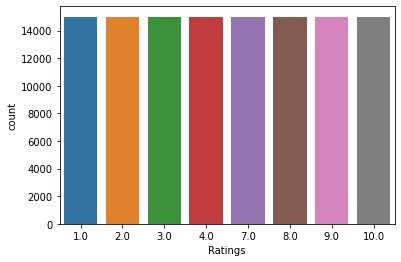

4.0     15000
8.0     15000
3.0     15000
1.0     15000
7.0     15000
2.0     15000
9.0     15000
10.0    15000
Name: Ratings, dtype: int64


In [40]:
#Checking for Class Imbalance 
sns.countplot(x=df['Ratings'])
plt.show()
print(df['Ratings'].value_counts())

(-0.5, 1499.5, 799.5, -0.5)

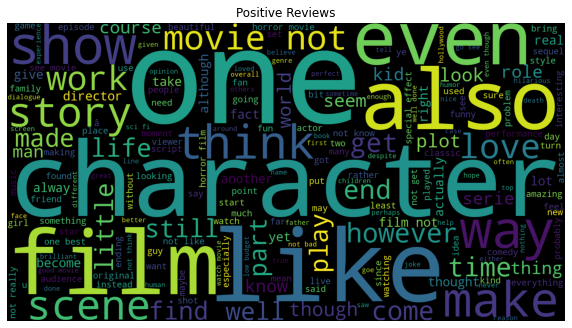

In [41]:
# Visualization of Important Words from positive Reviews

sentences=df['Reviews_clean']
pos=' '.join(map(str,sentences[df['Ratings']>=7]))
neg=' '.join(map(str,sentences[df['Ratings']<=4]))
  
pos_wordcloud = WordCloud(width = 1500, height = 800, 
                background_color ='black', 
                stopwords = stop_words, 
                min_font_size = 15).generate(pos) 

plt.figure(figsize=(10,10))
plt.imshow(pos_wordcloud)
plt.title('Positive Reviews')
plt.axis('off')

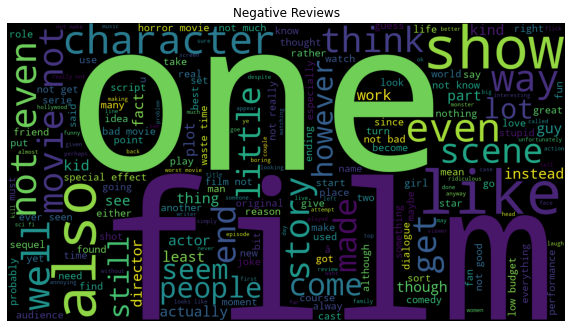

In [42]:
# # Visualization of Important Words from Negative Reviews

neg_wordcloud = WordCloud(width = 1500, height = 800, 
                background_color ='black', 
                stopwords = stop_words, 
                min_font_size = 15).generate(neg) 

plt.figure(figsize=(10,10))
plt.imshow(neg_wordcloud)
plt.title('Negative Reviews')
plt.axis('off')
plt.show() 

DATA CLEANING AND PREPROCESSING

In [30]:
# Customize stopwords
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
new_stopwords = ["would", "shall", "could", "might"]
stop_words.extend(new_stopwords)
stop_words.remove("not")
stop_words = set(stop_words)
logging.info("Stopwords customized.")
logging.debug(f"Stopwords: {stop_words}")

2024-07-15 14:46:42,271 - INFO - Stopwords customized.
2024-07-15 14:46:42,276 - DEBUG - Stopwords: {'under', 'from', 'other', 'having', 'on', 'shall', 'very', 'once', 'how', 'which', 'because', 'mustn', 'both', "needn't", 'over', 'the', 'should', 'don', 'but', 'didn', 'shan', 'who', 'aren', 'y', 'your', 'this', 'too', "hasn't", 'each', 'did', 'll', 'he', "it's", "mustn't", 'they', 'is', 'above', 'here', 'a', 'as', 'we', 'their', 'and', 'only', 'or', 'were', 'myself', 'in', 'if', 'theirs', 'ma', 'off', 'during', 'yourselves', 'about', "she's", 'are', 'nor', 'mightn', 't', 'hasn', 'couldn', 'at', 'down', "you'll", 'any', 'whom', 'ours', "weren't", 'needn', 've', 'isn', 'might', 'what', 'd', 'between', 'same', 'again', 'themselves', 'with', "you're", 'until', 'just', 're', "didn't", 'up', "shouldn't", "you'd", 'into', 'below', 'few', 'haven', 'itself', 'to', 'can', 'o', 'it', 'am', 'further', 'be', 'through', 'you', "that'll", "couldn't", 'will', 'yourself', "aren't", 'against', 'all', '

In [31]:
# Function definitions for data preprocessing
def remove_special_character(content):
    return re.sub('\W+', ' ', content)

def remove_url(content):
    return re.sub(r'http\S+', '', content)

def remove_stopwords(content):
    clean_data = [i.strip().lower() for i in content.split() if i.strip().lower() not in stop_words and i.strip().lower().isalpha()]
    return " ".join(clean_data)

def contraction_expansion(content):
    contractions = {
        r"won\'t": "would not", r"can\'t": "can not", r"don\'t": "do not",
        r"shouldn\'t": "should not", r"needn\'t": "need not", r"hasn\'t": "has not",
        r"haven\'t": "have not", r"weren\'t": "were not", r"mightn\'t": "might not",
        r"didn\'t": "did not", r"n\'t": " not"
    }
    for key, value in contractions.items():
        content = re.sub(key, value, content)
    return content

def data_cleaning(content):
    content = contraction_expansion(content)
    content = remove_special_character(content)
    content = remove_url(content)
    content = remove_stopwords(content)
    return content

In [32]:
try:
    logging.debug("Starting data cleaning process...")
    df['Reviews_clean'] = df['Reviews'].apply(data_cleaning)
    logging.info("Data cleaned successfully.")
    logging.debug(f"Sample cleaned data: {df['Reviews_clean'].head()}")
except Exception as e:
    logging.error(f"Error during data cleaning: {e}")
    raise

2024-07-15 14:46:48,397 - DEBUG - Starting data cleaning process...
2024-07-15 14:47:11,810 - INFO - Data cleaned successfully.
2024-07-15 14:47:11,825 - DEBUG - Sample cleaned data: 0    disclaimer watched movie conditional agreement...
1    writing hopes gets put previous review film an...
2    really write scathing review turd sandwich ins...
3    saw previous spoof movies two horrible gentlem...
4    movie saw day early free still feel like got r...
Name: Reviews_clean, dtype: object


In [33]:
# df.head(5)

FEATURE ENGINEERING

In [34]:
# Mapping rating data to Binary label
try:
    logging.debug("Mapping ratings to binary labels...")
    df['Label'] = df['Ratings'].apply(lambda x: '1' if x >= 7 else ('0' if x <= 4 else '2'))
    df = df[df.Label < '2']
    data = df[['Reviews_clean', 'Reviews', 'Ratings', 'Label']]
    data['Label'] = data['Label'].astype(int)  # Convert label to integer type
    logging.info("Labels created and data filtered.")
    logging.debug(f"Label distribution: {df['Label'].value_counts()}")
except Exception as e:
    logging.error(f"Error during label creation: {e}")
    raise

2024-07-15 14:47:11,876 - DEBUG - Mapping ratings to binary labels...
2024-07-15 14:47:11,978 - INFO - Labels created and data filtered.
2024-07-15 14:47:11,993 - DEBUG - Label distribution: 1    60000
0    60000
Name: Label, dtype: int64


LEMMATIZATION

In [35]:
# Import dependencies for feature engineering
from sklearn.feature_extraction.text import TfidfVectorizer

class LemmaTokenizer(object):
    def __init__(self):
        self.wordnetlemma = WordNetLemmatizer()

    def __call__(self, reviews):
        return [self.wordnetlemma.lemmatize(word) for word in word_tokenize(reviews)]

In [36]:
try:
    logging.debug("Starting train-test split...")
    train, test = train_test_split(data, test_size=.3, random_state=42, shuffle=True)
    tfidfvect = TfidfVectorizer(analyzer="word", tokenizer=LemmaTokenizer(), ngram_range=(1, 3), min_df=10, max_features=10000)
    logging.debug("Fitting TF-IDF vectorizer on training data...")
    x_train_tfidf = tfidfvect.fit_transform(train['Reviews_clean']).toarray()
    logging.debug("Transforming test data using TF-IDF vectorizer...")
    x_test_tfidf = tfidfvect.transform(test['Reviews_clean']).toarray()
    y_train = train['Label']
    y_test = test['Label']
    logging.info("Feature engineering completed.")
    logging.debug(f"TF-IDF training data shape: {x_train_tfidf.shape}")
    logging.debug(f"TF-IDF test data shape: {x_test_tfidf.shape}")
except Exception as e:
    logging.error(f"Error during feature engineering: {e}")
    raise

2024-07-15 14:47:12,024 - DEBUG - Starting train-test split...
2024-07-15 14:47:12,041 - DEBUG - Fitting TF-IDF vectorizer on training data...
2024-07-15 14:49:29,173 - DEBUG - Transforming test data using TF-IDF vectorizer...
2024-07-15 14:50:10,733 - INFO - Feature engineering completed.
2024-07-15 14:50:10,734 - DEBUG - TF-IDF training data shape: (84000, 10000)
2024-07-15 14:50:10,735 - DEBUG - TF-IDF test data shape: (36000, 10000)


### MODEL TRAINING AND EVALUATION

MACHINE LEARNING MODEL - RANDOM FOREST

2024-07-15 14:50:15,217 - DEBUG - Initializing Random Forest model...
2024-07-15 14:50:15,222 - DEBUG - Training Random Forest model...
2024-07-15 14:59:51,480 - INFO - Random Forest model trained successfully.
2024-07-15 15:01:17,797 - INFO - Random Forest model evaluation:
2024-07-15 15:01:17,997 - INFO - Train Precision: 0.9999761904761905
2024-07-15 15:01:54,462 - INFO - Train AUC: 0.9999902940768302
2024-07-15 15:01:54,545 - INFO - Train F1: 0.9999761904783365
2024-07-15 15:01:54,564 - INFO - Test Precision: 0.8553055555555555
2024-07-15 15:02:06,831 - INFO - Test AUC: 0.9284129903473854
2024-07-15 15:02:06,844 - INFO - Test F1: 0.8553044254705882


Random Forest Classification Report:
%s               precision    recall  f1-score   support

           0       0.86      0.86      0.86     18160
           1       0.85      0.85      0.85     17840

    accuracy                           0.86     36000
   macro avg       0.86      0.86      0.86     36000
weighted avg       0.86      0.86      0.86     36000

Accuracy Score: %s 0.8553055555555555


2024-07-15 15:02:07,178 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x0000026522E584C0>


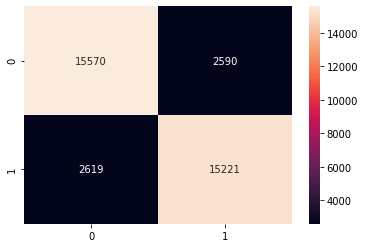

In [37]:
# Model training and evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

try:
    logging.debug("Initializing Random Forest model...")
    rf_clf = RandomForestClassifier()
    logging.debug("Training Random Forest model...")
    rf_clf.fit(x_train_tfidf, y_train)
    logging.info("Random Forest model trained successfully.")

    y_train_pred = rf_clf.predict(x_train_tfidf)
    y_test_pred = rf_clf.predict(x_test_tfidf)
    y_train_proba = rf_clf.predict_proba(x_train_tfidf)[:, 1]
    y_test_proba = rf_clf.predict_proba(x_test_tfidf)[:, 1]

    
    logging.info("Random Forest model evaluation:")
    logging.info(f"Train Precision: {precision_score(y_train, y_train_pred, average='micro')}")
    logging.info(f"Train AUC: {roc_auc_score(pd.get_dummies(y_train), rf_clf.predict_proba(x_train_tfidf), multi_class='ovo', average='macro')}")
    logging.info(f"Train F1: {f1_score(y_train, y_train_pred, average='weighted')}")
    logging.info(f"Test Precision: {precision_score(y_test, y_test_pred, average='micro')}")
    logging.info(f"Test AUC: {roc_auc_score(pd.get_dummies(y_test), rf_clf.predict_proba(x_test_tfidf), multi_class='ovo', average='macro')}")
    logging.info(f"Test F1: {f1_score(y_test, y_test_pred, average='weighted')}")
    print("Random Forest Classification Report:\n%s", classification_report(y_test, y_test_pred))
    print("Accuracy Score: %s", accuracy_score(y_test, y_test_pred))
    cm = confusion_matrix(y_test, y_test_pred)
    cm_matrix = pd.DataFrame(data=cm)
    sns.heatmap(cm_matrix, annot=True, fmt='d')
    plt.show()
except Exception as e:
    logging.error(f"Error during Random Forest model training/evaluation: {e}")
    raise

DEEP LEARNING MODEL - LSTM CLASSIFIER

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler

class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        h0 = torch.zeros(self.n_layers * 2 if self.bidirectional else self.n_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.n_layers * 2 if self.bidirectional else self.n_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(self.dropout(out[:, -1, :]))
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [45]:
try:
    logging.debug("Preparing data for LSTM model...")
    x_train_tensor = torch.tensor(x_train_tfidf, dtype=torch.float32).unsqueeze(1)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
    x_test_tensor = torch.tensor(x_test_tfidf, dtype=torch.float32).unsqueeze(1)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

    input_dim = x_train_tfidf.shape[1]
    hidden_dim = 128
    output_dim = 2
    n_layers = 2
    bidirectional = True
    dropout = 0.3

    model = LSTMClassifier(input_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)
    model = model.to(device)

    train_data = TensorDataset(x_train_tensor, y_train_tensor)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=32)

    test_data = TensorDataset(x_test_tensor, y_test_tensor)
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=32)

    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss().to(device)
    logging.info("LSTM model setup completed.")
except Exception as e:
    logging.error(f"Error during LSTM model setup: {e}")
    raise

2024-07-15 15:10:42,514 - DEBUG - Preparing data for LSTM model...
2024-07-15 15:11:04,115 - INFO - LSTM model setup completed.


In [46]:
try:
    logging.debug("Starting LSTM model training...")
    epochs = 10
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for step, batch in enumerate(train_dataloader):
            batch_inputs, batch_labels = batch
            batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)

            optimizer.zero_grad()
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_labels)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

            # logging.debug(f"Epoch {epoch+1}, Step {step+1}, Loss: {loss.item()}")

        avg_train_loss = total_loss / len(train_dataloader)
        logging.info(f"Epoch {epoch + 1}, Average Training Loss: {avg_train_loss}")
except Exception as e:
    logging.error(f"Error during LSTM model training: {e}")
    raise

2024-07-15 15:11:04,182 - DEBUG - Starting LSTM model training...
2024-07-15 15:15:20,228 - INFO - Epoch 1, Average Training Loss: 0.28182951508817217
2024-07-15 15:19:20,151 - INFO - Epoch 2, Average Training Loss: 0.21422159755088035
2024-07-15 15:23:22,154 - INFO - Epoch 3, Average Training Loss: 0.184882892805196
2024-07-15 15:27:27,111 - INFO - Epoch 4, Average Training Loss: 0.15981998347420068
2024-07-15 15:31:27,731 - INFO - Epoch 5, Average Training Loss: 0.13550904281827666
2024-07-15 15:35:25,516 - INFO - Epoch 6, Average Training Loss: 0.10870589474473326
2024-07-15 15:39:30,946 - INFO - Epoch 7, Average Training Loss: 0.07954876619616214
2024-07-15 15:43:46,957 - INFO - Epoch 8, Average Training Loss: 0.04709303186377344
2024-07-15 15:48:10,637 - INFO - Epoch 9, Average Training Loss: 0.02734728823577011
2024-07-15 15:52:33,016 - INFO - Epoch 10, Average Training Loss: 0.019226971150352084


In [48]:
def evaluate_model(dataloader):
    model.eval()
    predictions, true_labels = [], []

    for batch in dataloader:
        batch_inputs, batch_labels = batch
        batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)

        with torch.no_grad():
            outputs = model(batch_inputs)

        logits = outputs.detach().cpu().numpy()
        label_ids = batch_labels.cpu().numpy()

        predictions.append(logits)
        true_labels.append(label_ids)

    predictions = np.concatenate(predictions, axis=0)
    true_labels = np.concatenate(true_labels, axis=0)
    return predictions, true_labels

2024-07-15 15:52:56,488 - DEBUG - Evaluating LSTM model on training data...
2024-07-15 15:54:02,231 - DEBUG - Evaluating LSTM model on test data...
2024-07-15 15:54:33,647 - INFO - LSTM model evaluation:
2024-07-15 15:54:33,786 - INFO - Train Precision: 0.9988333333333334
2024-07-15 15:54:33,929 - INFO - Train AUC: 0.9999853210738205
2024-07-15 15:54:33,966 - INFO - Train F1: 0.9988333348571609
2024-07-15 15:54:33,986 - INFO - Test Precision: 0.8726111111111111
2024-07-15 15:54:34,004 - INFO - Test AUC: 0.9460641211157426
2024-07-15 15:54:34,032 - INFO - Test F1: 0.8726014464731018
2024-07-15 15:54:34,264 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x000002652D725400>


LSTM Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.88      0.87     18160
           1       0.88      0.87      0.87     17840

    accuracy                           0.87     36000
   macro avg       0.87      0.87      0.87     36000
weighted avg       0.87      0.87      0.87     36000

Accuracy Score: %s 0.8726111111111111


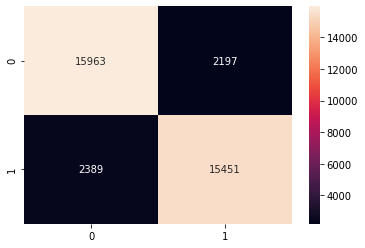

In [49]:
try:
    logging.debug("Evaluating LSTM model on training data...")
    train_predictions, train_true_labels = evaluate_model(train_dataloader)
    logging.debug("Evaluating LSTM model on test data...")
    test_predictions, test_true_labels = evaluate_model(test_dataloader)

    train_pred_labels = np.argmax(train_predictions, axis=1)
    test_pred_labels = np.argmax(test_predictions, axis=1)

    logging.info("LSTM model evaluation:")
    logging.info(f"Train Precision: {precision_score(train_true_labels, train_pred_labels, average='micro')}")
    logging.info(f"Train AUC: {roc_auc_score(pd.get_dummies(train_true_labels), train_predictions, multi_class='ovo', average='macro')}")
    logging.info(f"Train F1: {f1_score(train_true_labels, train_pred_labels, average='weighted')}")
    logging.info(f"Test Precision: {precision_score(test_true_labels, test_pred_labels, average='micro')}")
    logging.info(f"Test AUC: {roc_auc_score(pd.get_dummies(test_true_labels), test_predictions, multi_class='ovo', average='macro')}")
    logging.info(f"Test F1: {f1_score(test_true_labels, test_pred_labels, average='weighted')}")
    print("LSTM Classification Report:\n", classification_report(test_true_labels, test_pred_labels))
    print("Accuracy Score: %s", accuracy_score(test_true_labels, test_pred_labels))
    cm = confusion_matrix(test_true_labels, test_pred_labels)
    cm_matrix = pd.DataFrame(data=cm)
    sns.heatmap(cm_matrix, annot=True, fmt='d')
    plt.show()
except Exception as e:
    logging.error(f"Error during LSTM model evaluation: {e}")
    raise

###  MODEL INTERPRETATION

SHAP FOR RANDOM FOREST

100%|===================| 71999/72000 [240:01<00:00]         

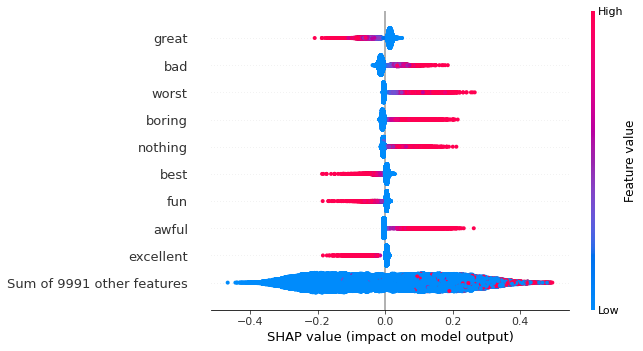

In [19]:
import shap

try:
    logging.debug("Initializing SHAP for Random Forest...")
    shap.initjs()

    explainer_rf = shap.Explainer(rf_clf, x_train_tfidf, feature_names=tfidfvect.get_feature_names_out())
    shap_values_rf = explainer_rf(x_test_tfidf)

    logging.info("Creating SHAP beeswarm plot for Random Forest...")
    shap.plots.beeswarm(shap_values_rf[..., 0])  # Beeswarm plot for class 0
    logging.info("SHAP beeswarm plot for Random Forest created.")
except Exception as e:
    logging.error(f"Error during SHAP analysis for Random Forest: {e}")
    raise

SHAP FOR LSTM

100%|██████████| 1/1 [00:18<00:00, 18.35s/it]


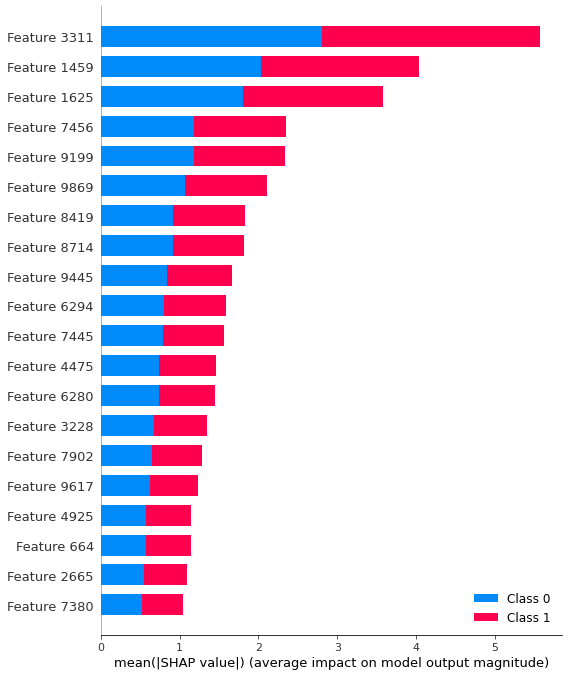

In [29]:
import shap

def predict_fn(data):
    model.eval()
    data = torch.tensor(data, dtype=torch.float32).unsqueeze(1).to(device)
    with torch.no_grad():
        outputs = model(data)
    return outputs.cpu().numpy()

try:
    logging.info("Initializing SHAP for LSTM...")
    explainer_lstm = shap.KernelExplainer(predict_fn, x_test_tfidf[:10])  # Smaller subset for background
    shap_values_lstm = explainer_lstm.shap_values(x_test_tfidf[:1])  # Smaller subset for explanation

    logging.debug("Creating SHAP summary plot for LSTM...")
    shap.summary_plot(shap_values_lstm, x_test_tfidf[:10])
    logging.info("SHAP summary plot for LSTM created.")
except Exception as e:
    logging.error(f"Error during SHAP analysis for LSTM: {e}")
    raise